In [1]:
import sys
path = '<git>/speedsim'
if path not in sys.path:
    sys.path.append(path)


# MTL Hardware description

### MTL Composed of:
#####    - 2 Atoms quad
#####    - 2 Big cores
#####    - 1 GT
#####    - LLC & DDR memories
#####    - They are connected to Bus (1 port for quad)

In [2]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY

Validating System platform: MTL...
System platform is valid!


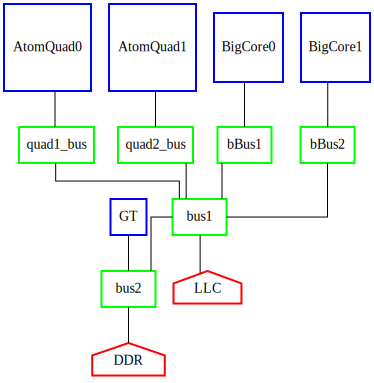

In [3]:

PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.01).instance
a_clk = Clock("a_clk", 0.01)    # 10 ns
b_clk = Clock("b_clk", 0.01)    # 10 ns
g_clk = Clock("g_clk", 0.01)    # 10 ns
sys_platform.add_clock(clk)

# IPs:
# - Ports
# - Drivers
# - Executing units

# Atoms
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)
    
# Big cores
bCores = dict()
for i in range(2):
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)

    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)

# GT 
gt_p = Port('p')
gt_dr = Driver('dr', g_clk)
gt_ex = ExecutingUnit('ex_u', g_clk)

gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)
sys_platform.add_bus(quad1_bus)
sys_platform.add_bus(quad2_bus)
sys_platform.add_bus(bBus1)
sys_platform.add_bus(bBus2)

# System buses
bus1 = Bus('bus1', clk, 64)
bus2 = Bus('bus2', clk, 64)
sys_platform.add_bus(bus1)
sys_platform.add_bus(bus2)

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memory(llc)
sys_platform.add_memory(ddr)

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)

sys_platform.validate_platform()
sys_platform

In [4]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()


Loading BokehJS ...

# VPB

### Loading VPB into SpeedSim directly - replay as it is

In [5]:
from pnets.simulation import Simulator
from pnets.pn_model import PnmlModel
fd = open('<pnml_path>', 'r')
vpb_pnml_model = PnmlModel.read(fd)

hw_resources = {'CPU': 4, 'GT_GFX': 1}
sim = Simulator(vpb_pnml_model, hw_resources)
res = sim.run(100000)

#### VPB reference results

In [6]:

clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['CPU{}'.format(i) for i in range(4)] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

# Atom first & Power aware scheduler
#### Preferes to map task of map type "Core" to atoms first, if no atom is available then map to big cores
#### Checks the first if resources are awake, if they are not awake then ask to wake them up and wait

In [5]:
from asap.schedulers import BaseSystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState
from collections import namedtuple

class AtomFirstScheduler:
    """
    Atom first scheduler:
        prefer tasks that should be mapped to resource of type core to atoms first with penalty, if all atoms are busy then map to CPU
    """
    def __init__(self, system_mgr):
        self._system_mgr = system_mgr
        self._base_scheduler = BaseSystemScheduler(self._system_mgr)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]

    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips

    def schedule_task(self, task, resource=None):
        if resource is not None:
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, resource)])
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._base_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._base_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._base_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        else:
            return self._base_scheduler.schedule_task(task, list())

    def on_task_finish(self, task):
        self._base_scheduler.on_task_finish(task)


# APM and Atom in VPB

In [6]:
from pnets.pn_model import PnmlModel
fd = open('<pnml_path>', 'r')
vpb_pnml_model = PnmlModel.read(fd)

from asap.strings import TaskMetaData
from asap.utils import from_pnml_model
from speedsim import SpeedSim
from models.power.apm.apm import APM, SpeedSimListener
from models.power.apm.updater import Updater



hw_resources = {'CPU': {'resource': atoms['AtomQuad0'][0], 'attributes': {'MAP_TYPE': 'Core'}}, 'GT_GFX': {'resource': gt, 'attributes': {'MAP_TYPE': 'GT'}}}
workload, mapping = from_pnml_model(vpb_pnml_model, 'workload', 1, hw_resources)
# for s in workload.get_start_tasks():
#     s.set_property(TaskMetaData.ITERATIONS, 10)

a_clk.period = 0.0005 # 2000MHz
b_clk.period = 0.00025
g_clk.period = 0.001 # 



sys_platform.reset()
speedsim = SpeedSim(sys_platform, workload, mapping, sim_scheduler=APM, system_scheduler=AtomFirstScheduler)
listener = SpeedSimListener()
updater = Updater(listener, apm=speedsim.sim_scheduler)
speedsim.sim_scheduler.instantiate(updater, listener, 10.0)
res = speedsim.simulate(5000000)


### Atoms first results

In [7]:
clear_results = res[res['RESOURCE'] != 'NULL']
ys = ['AtomQuad0/ex_u{}'.format(i) for i in range(4)] + ['AtomQuad1/ex_u{}'.format(i) for i in range(4)] + ['BigCore0__ex_u', 'BigCore1__ex_u'] + ['GT/ex_u']
fig = figure(plot_width=1000, plot_height=800, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=ys, tooltips=[('name', '@NAME')])

interval_graph(fig, clear_results)
show(fig)

## Frequency data

In [8]:
frequency_data = speedsim.sim_scheduler.get_frequency_data()
frequency_data

,TIME,RESOURCE,CLOCK,FREQUENCY
0,10.0,AtomQuad0/driver,a_clk,1000
1,10.0,AtomQuad0/ex_u0,a_clk,1000
2,10.0,AtomQuad0/ex_u1,a_clk,1000
3,10.0,AtomQuad0/ex_u2,a_clk,1000
4,10.0,AtomQuad0/ex_u3,a_clk,1000
5,10.0,AtomQuad1/driver,a_clk,1000
6,10.0,AtomQuad1/ex_u0,a_clk,1000
7,10.0,AtomQuad1/ex_u1,a_clk,1000
8,10.0,AtomQuad1/ex_u2,a_clk,1000
9,10.0,AtomQuad1/ex_u3,a_clk,1000


# C States data

In [9]:
cstates = speedsim.sim_scheduler.get_cstates_data()
cstates

,TIME,RESOURCE,C_STATE
0,10.000000,AtomQuad0/driver,C6
1,10.000000,AtomQuad1/driver,C6
2,10.000000,BigCore0/driver,C6
3,10.000000,BigCore1/driver,C6
4,10.000000,GT/dr,C6
5,10.000000,AtomQuad0/ex_u2,C6
6,10.000000,AtomQuad0/ex_u3,C6
7,10.000000,AtomQuad1/ex_u0,C6
8,10.000000,AtomQuad1/ex_u1,C6
9,10.000000,AtomQuad1/ex_u2,C6


In [10]:
from asap.strings import NAME_SEPARATOR
from bokeh.palettes import Category10
from bokeh.plotting import gridplot
from itertools import cycle

palette = cycle(Category10[10])

resources = cstates.RESOURCE.unique()
graphs = list()
for r in resources:
    s_fig = figure(plot_width=1000, plot_height=200, tools=['xpan', 'xwheel_zoom'], active_scroll='xwheel_zoom', y_range=['C0', 'C6'])
    s_fig.yaxis.axis_label = 'C-State'
#     r = res.ip.name + NAME_SEPARATOR + res.name
    subset = cstates.loc[cstates['RESOURCE'] == r, ['TIME', 'C_STATE']]
    s_fig.step(x=subset['TIME'].values, y=subset['C_STATE'].values, mode='after', legend='res {}'.format(r), color=next(palette))
    graphs.append([s_fig])

show(gridplot(graphs))

## Analysis

In [11]:
from post_processing.utils import get_hw_analysis, HWData, window_res
from asap.strings import ResourceDesc
ip_table, ip_res = get_hw_analysis(ResourceDesc.IP, 1000)
# memory_table, memory_res = get_hw_analysis(ResourceDesc.MEMORY, 1000)
# bus_table, bus_res = get_hw_analysis(ResourceDesc.BUS, 1000)
# ip_window = window_res(ip_table, 1500, 2200)
ip_res

,0.00-1000.00,1000.00-2000.00,2000.00-3000.00,3000.00-4000.00,4000.00-5000.00,5000.00-6000.00,6000.00-7000.00,7000.00-8000.00,8000.00-9000.00,9000.00-10000.00,...,124000.00-125000.00,125000.00-126000.00,126000.00-127000.00,127000.00-128000.00,128000.00-129000.00,129000.00-130000.00,130000.00-131000.00,131000.00-132000.00,132000.00-133000.00,133000.00-134000.00
AtomQuad0/ex_u0,2.351257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.400000,86.449371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.974274
AtomQuad0/ex_u1,7.665555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113333,44.397296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.157911
AtomQuad0/ex_u2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,14.129565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AtomQuad0/ex_u3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,16.852277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AtomQuad1/ex_u1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,20.740525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AtomQuad1/ex_u0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21.187964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
GT/ex_u,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AtomQuad1/ex_u2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AtomQuad1/ex_u3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
BigCore0/ex_u,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
